In [108]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')
os.environ['HUGGINGFACE_API_KEY'] = os.getenv('HUGGINGFACE_API_KEY')

In [109]:
from typing import Literal
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [110]:
model = ChatGroq(model_name="qwen/qwen3-32b")

### this is my custom tool

In [111]:
@tool
def multiply(a: int, b: int) -> int:
    """Mutiply two numbers together."""
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add two numbers together."""
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide two numbers together."""
    return a / b

### importing the inbuilt tool

In [112]:
from langchain_community.tools import DuckDuckGoSearchRun
search =  DuckDuckGoSearchRun()

In [113]:
# search.invoke("what is apple inc?")

In [114]:
tools = [multiply,add,divide,search]

### binding tools with llm. 
So llm will call the tools which ever is appropriate for the question base on its thinking process and calls it.

In [115]:
llm_with_tools = model.bind_tools(tools)

Here the llm doesn't require the tools to call since it is "Hi" 

In [116]:
response = llm_with_tools.invoke("Hi")

In [117]:
response.content

'Hi! How can I assist you today?'

In [118]:
response.tool_calls

[]

Here it is calling the tool to get the stock price of apple

In [119]:
response = llm_with_tools.invoke("what is apple inc's stock price?")

In [120]:
response.content

''

In [121]:
response.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'Apple Inc stock price'},
  'id': 'drevr86xc',
  'type': 'tool_call'}]

Here it is using the tool to get additon of it

In [122]:
response = llm_with_tools.invoke("what is 2 + 6?")

In [123]:
response.content

''

In [124]:
response.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 6},
  'id': 'peh7a9pea',
  'type': 'tool_call'}]

### Creting a tool node

In [125]:
tool_node = ToolNode(tools)

In [126]:
workflow = StateGraph(MessagesState)

In [127]:
def function_1(state: MessagesState):
    question = state["messages"]
    prompt = ["You are a helpful assistant. Task is to use a appropriate tool for the following question"] + question
    response = llm_with_tools.invoke(prompt)
    return {"messages": [response]}


In [128]:
workflow.add_node("llm_decision_step", function_1)

In [129]:
workflow.add_edge(START, "llm_decision_step")

In [130]:
workflow.add_node("tools", tool_node)

In [131]:
from langgraph.prebuilt import tools_condition
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition
)

In [132]:
workflow.add_edge("tools", "llm_decision_step")

In [133]:
app = workflow.compile()

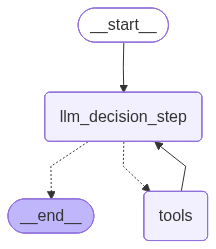

In [134]:
app

In [135]:
app.invoke({"messages": ["What is 2*6 and who is modi?"]})

{'messages': [HumanMessage(content='What is 2*6 and who is modi?', additional_kwargs={}, response_metadata={}, id='5dc23261-ff41-463a-bbd3-5dda1f3ee749'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, let\'s see. The user asked two questions: "What is 2*6?" and "Who is Modi?" \n\nFirst, for the math problem, 2 multiplied by 6. I remember there\'s a function called multiply that takes two integers. So I can use the multiply tool here. The parameters would be a=2 and b=6.\n\nThen, the second question is about who Modi is. That\'s a factual question about a person. Since Modi is a public figure, I need to get up-to-date information. The best tool for that is the DuckDuckGo search. I should use the duckduckgo_search function with the query "Who is Narendra Modi?" to get the latest info. \n\nWait, the user just said "modi". Maybe they mean Narendra Modi, the Prime Minister of India. So the search query should be specific. I need to make sure the search term is accur

In [136]:
response = app.invoke({"messages": ["What is 8129/4? speed of light?"]})

In [137]:
response["messages"][-1].content

"The result of 8129 divided by 4 is **2032.25**.  \n\nThe speed of light in a vacuum is approximately **299,792,458 meters per second (m/s)**. Let me know if you'd like it converted to other units!"

In [138]:
for r in response["messages"]:
    r.pretty_print()

================================ Human Message =================================

What is 8129/4? speed of light?
================================== Ai Message ==================================
Tool Calls:
  divide (x69c03tn1)
 Call ID: x69c03tn1
  Args:
    a: 8129
    b: 4
================================= Tool Message =================================
Name: divide

2032.25
================================== Ai Message ==================================

The result of 8129 divided by 4 is **2032.25**.  

The speed of light in a vacuum is approximately **299,792,458 meters per second (m/s)**. Let me know if you'd like it converted to other units!


In [139]:
import yfinance as yf

In [140]:
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

In [141]:
get_stock_price.invoke("AAPL")

'The last closing price of AAPL was $258.28.'

In [142]:
get_stock_price.invoke("TSLA")

'The last closing price of TSLA was $416.57.'

In [143]:

tools = [add, multiply, divide, search,get_stock_price]

In [144]:

llm_with_tools=model.bind_tools(tools)

In [145]:
response=llm_with_tools.invoke("can you give me a latest stock price of adani greens?")

In [146]:
response.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.NS'},
  'id': 'e96j2ekha',
  'type': 'tool_call'}]

In [147]:
SYSTEM_PROMPT = SystemMessage(
    content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs."
)
def function_1(state:MessagesState):
    
    user_question=state["messages"]
    
    input_question = [SYSTEM_PROMPT]+user_question
    
    response = llm_with_tools.invoke(input_question)
    
    return {
        "messages":[response]
    }

In [148]:
workflow = StateGraph(MessagesState)
workflow.add_node("llm_decision_step", function_1)
workflow.add_node("tools", ToolNode(tools))
workflow.add_edge(START, "llm_decision_step")
workflow.add_conditional_edges(
    "llm_decision_step",
    tools_condition,
)
workflow.add_edge("tools", "llm_decision_step")
react_graph2 = workflow.compile()

In [149]:
messages = [HumanMessage(content="add 1000 in the current stock price of Apple.")]
messages = react_graph2.invoke({"messages": messages})

In [150]:

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

add 1000 in the current stock price of Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (361ngq7r7)
 Call ID: 361ngq7r7
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $258.28.
================================== Ai Message ==================================
Tool Calls:
  add (c7ahnv80s)
 Call ID: c7ahnv80s
  Args:
    a: 258
    b: 1000
================================= Tool Message =================================
Name: add

1258
================================== Ai Message ==================================

The current stock price of Apple (AAPL) is $258.28. Adding $1,000 to this price gives:

**$258.28 + $1,000 = $1,258.28**

Final result: **$1,258.28**


In [151]:
messages = [HumanMessage(content="can you give me 2 times of current stock price of Apple with the latest news of the Apple.")]
messages = react_graph2.invoke({"messages": messages})

In [152]:

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

can you give me 2 times of current stock price of Apple with the latest news of the Apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (6dtcb7tzt)
 Call ID: 6dtcb7tzt
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $258.28.
================================== Ai Message ==================================
Tool Calls:
  multiply (t2n9vkpff)
 Call ID: t2n9vkpff
  Args:
    a: 258
    b: 2
  duckduckgo_search (3m430wrz3)
 Call ID: 3m430wrz3
  Args:
    query: latest news on Apple
================================= Tool Message =================================
Name: multiply

516
================================= Tool Message =================================
Name: duckduckgo_search

14 Jan 2026 · Latest News ; Apple reports first 